## NLP solver reference
- sciPy
    - https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html#constrained-minimization-of-multivariate-scalar-functions-minimize
    - https://docs.scipy.org/doc/scipy/reference/optimize.html

In [1]:
from scipy.optimize import minimize
from scipy.optimize import Bounds

import matplotlib.pyplot as plt
import numpy as np
import time

## simple optimization example

In [2]:
def rosen(x):
    """The Rosenbrock function"""
    return sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)

x0 = np.array([1.3, 0.7, 0.8, 1.9, 1.2])
res = minimize(rosen, x0, method='nelder-mead', options={'xatol': 1e-8, 'disp': True})

print(res.message, res.success, res.x, res.fun)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 339
         Function evaluations: 571
Optimization terminated successfully. True [1. 1. 1. 1. 1.] 4.861153433422115e-17


state 및 control을 N개의 piece-wise로 쪼갠다고 가정.
$$
x[0] : t_{f} \\
x[1:N+2] : u_0, u_1, ..., u_N \\
x[N+2:3*N+4] : x_0, \dot{x}_0, x_1, \dot{x}_1, ..., x_N, \dot{x}_N \\
$$

In [3]:
def dynamics(x, u):
    A_mat = np.array([[0, 1], [0, 0]])
    B_mat = np.array([[0], [1]])
    result = np.matmul(A_mat, x) + np.matmul(B_mat, u)
    return result

In [4]:
def obj_func(x):
    f = x[0]
    return f

def obj_jacobian(x):
    jacobian = np.zeros((1, len(x)))
    jacobian[0, 0] = 1.0
    return jacobian

In [9]:
def eq_cons_func(x):
    N = int((len(x) - 1)/3 - 1)
    t_f = x[0]
    u_list = np.array(x[1:N+2]).reshape((N+1, 1))
    x_list = np.array(x[N+2:]).reshape((N+1, 2))
    dt = t_f/N
    
    # get x_dot from dynamics
    x_dot_list = dynamics(x_list.T, u_list.T).T
    
    # transform variables for pice-wise polynomial
    x_left = x_list[:N,:]
    x_right = x_list[1:,:]
    x_dot_left = x_dot_list[:N,:]
    x_dot_right = x_dot_list[1:,:]
    u_left = u_list[:N,:]
    u_right = u_list[1:,:]
    
    # get collocation points
    x_c = 0.5*(x_left + x_right) + dt*0.125*(x_dot_left - x_dot_right)
    u_c = 0.5*(u_left + u_right)
    x_dot_c = dynamics(x_c.T, u_c.T).T

    # equality constraint
    eq_cons = list(np.ravel(x_left - x_right + dt*(x_dot_left + 4*x_dot_c + x_dot_right)/6)) # 2N 개
    eq_cons += [x_list[0,0], x_list[0,1], x_list[N,0] - 10.0, x_list[N,1]] # 4 개

    return eq_cons

'''
def eq_cons_jacobian(x):
    N = int((len(x) - 1)/3 - 1)
    t_f = x[0]
    u_list = np.array(x[1:N+2]).reshape((N+1, 1))
    x_list = np.array(x[N+2:]).reshape((N+1, 2))
    dt = t_f/N
    
    # get x_dot from dynamics
    x_dot_list = dynamics(x_list.T, u_list.T).T
    
    # transform variables for pice-wise polynomial
    x_left = x_list[:N,:]
    x_right = x_list[1:,:]
    x_dot_left = x_dot_list[:N,:]
    x_dot_right = x_dot_list[1:,:]
    u_left = u_list[:N,:]
    u_right = u_list[1:,:]

    # get collocation points
    x_c = 0.5*(x_left + x_right) + dt*0.125*(x_dot_left - x_dot_right)
    u_c = 0.5*(u_left + u_right)
    x_dot_c = dynamics(x_c.T, u_c.T).T

    jacobian = np.zeros((2*N+4, 3*N+4))
    for i in range(N):
        jacobian[2*i:2*(i+1), 0] = (x_dot_left[i] + 4*x_dot_c[i] + x_dot_right[i])/6

        jacobian[2*i, N+2+i*2] = 1
        jacobian[2*i+1, N+3+i*2] = 1

        jacobian[2*i, N+2+(i+1)*2] = -1
        jacobian[2*i+1, N+3+(i+1)*2] = -1

    jacobian[2*N, N+2] = 1
    jacobian[2*N+1, N+3] = 1
    jacobian[2*N+2, 3*N+2] = 1
    jacobian[2*N+3, 3*N+3] = 1
    return jacobian
'''
eq_cons = {
    'type':'eq',
    'fun' :eq_cons_func,
    #'jac' :eq_cons_jacobian,
    }

In [10]:
N = 100
t_f_init = 10.0
u_init = np.zeros((N+1,1))
state_init = np.zeros((N+1,2))
x_init = np.concatenate([[t_f_init], u_init.ravel(), state_init.ravel()])
#print(x_init)
bounds = Bounds([0.0] + [-1.0]*(N+1) + [-np.inf]*(2*N+2), [np.inf] + [1.0]*(N+1) + [np.inf]*(2*N+2))
#print(bounds)

In [11]:
start_t = time.time()
res = minimize(obj_func, x_init, method="SLSQP", jac=obj_jacobian, bounds=bounds, constraints=[eq_cons], \
               options={'ftol':1e-3, 'disp':True, 'maxiter':100, 'eps':1e-7})
print("elapsed time : {:.5f} s".format(time.time() - start_t))

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 6.340913791063328
            Iterations: 28
            Function evaluations: 28
            Gradient evaluations: 28
elapsed time : 2.74688 s


[[ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [ 1.        ]
 [ 0.90273046]
 [ 0.79803727]
 [ 0.74008827]
 [ 0.65741353]
 [ 0.55445079]
 [ 0.43330627]
 [ 0.30795831]
 [ 0.15958015]
 [-0.03150568]
 [-0.2460746 ]
 [-0.48631997]
 [-0.7896648 ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.     

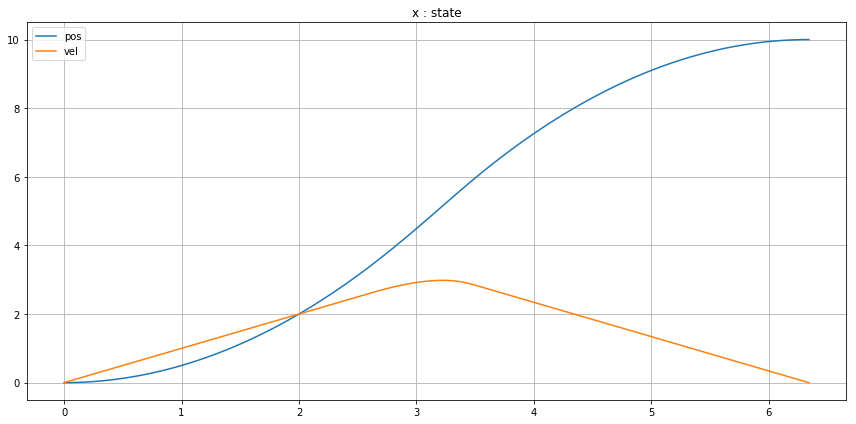

In [12]:
N = int((len(res.x) - 1)/3 - 1)
t_f = res.x[0]
t_list = np.linspace(0, t_f, N+1)
u_list = np.array(res.x[1:N+2]).reshape((N+1, 1))
x_list = np.array(res.x[N+2:]).reshape((N+1, 2))
print(u_list)

fig_size = 6
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(fig_size*2, fig_size))
ax.plot(t_list, x_list[:,0], label="pos")
ax.plot(t_list, x_list[:,1], label="vel")
#ax.set_ylim(-1, 10)
ax.grid()
ax.legend()
ax.set_title('x : state')

fig.tight_layout()
plt.show()